In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D,GlobalMaxPooling1D,MaxPooling1D
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization,CuDNNLSTM
from tensorflow import keras
import string

In [17]:
train = pd.read_csv('/content/drive/MyDrive/toxic_5.csv')

In [18]:
train['comment_text'] = pd.DataFrame(train["comment_text"].astype('str')) 

In [19]:
import re
!pip install contractions
import contractions


i=0
for doc in train.comment_text:
    doc = doc.lower()
    doc=  re.sub(r"https?://\S+|www\.\S+",'', doc)  #Remove URLs from a sample string
    doc = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', '', doc) # clean url
    doc = re.sub(r'#(\w+)', '',doc)   # clean hashes
    doc = re.sub(r'[^\x00-\x7f]',r'', doc) #Remove non-ASCII characters 
    doc = re.sub(r'@(\w+)', '', doc)   # clean @
    doc = re.sub(r'<[^>]+>', '',doc)  # clean tags
    doc = re.sub(r'\d+', '',doc)      # clean digits
    doc=re.sub(r'<.*?>','',doc)
    doc = re.sub("#", " ",doc)
    doc = re.sub(":::", " ", doc)
    doc = re.sub("\n", " ",doc)
    doc=re.sub(r'[^a-zA-Z\s]','',doc,re.I|re.A)
    punctuation = set(string.punctuation)  #remove the punctuation
    doc = "".join([p for p in doc if p not in punctuation])
    doc=contractions.fix(doc)
    train.comment_text[i]=doc
    i+=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
train['comment_text'] = pd.DataFrame(train["comment_text"].astype('str')) 

In [21]:
x=train["comment_text"]
y=train["Toxic"]

In [22]:
train_x, test_x, train_y, test_y = train_test_split(x,y, test_size=0.2, random_state=2,shuffle=True)

In [23]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"    
    
hub_layer = hub.KerasLayer(embedding,output_shape=[128], input_shape=[], dtype=tf.string, trainable=True)

In [25]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
bi_model=Sequential()
bi_model.add(hub_layer)
bi_model.add(tf.keras.layers.Reshape((1,128)))
bi_model.add(Dropout(0.3))
bi_model.add(Bidirectional(CuDNNLSTM(64,return_sequences=True)))
bi_model.add(Dropout(0.3))
bi_model.add(Bidirectional(CuDNNLSTM(64))) #lstm with 64 neurons
bi_model.add(Dropout(0.3))
bi_model.add(Dense(1,activation='sigmoid'))
bi_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(3e-3),metrics=['accuracy'])
print(bi_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 128)               124642688 
                                                                 
 reshape_4 (Reshape)         (None, 1, 128)            0         
                                                                 
 dropout_4 (Dropout)         (None, 1, 128)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 128)           99328     
 l)                                                              
                                                                 
 dropout_5 (Dropout)         (None, 1, 128)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              99328     
 nal)                                                 

In [27]:
callback=keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=5, verbose=2, mode='auto', restore_best_weights=True)
history = bi_model.fit(x=train_x, y=train_y, batch_size=64, verbose=1, epochs=20, validation_split= 0.1,shuffle=True,callbacks=[callback])

Epoch 1/20
462/462 [==============================] - 57s 124ms/step - loss: 0.2595 - accuracy: 0.8966 - val_loss: 0.2369 - val_accuracy: 0.9032
Epoch 2/20
462/462 [==============================] - 56s 121ms/step - loss: 0.1298 - accuracy: 0.9494 - val_loss: 0.2491 - val_accuracy: 0.9007
Epoch 3/20
462/462 [==============================] - 56s 121ms/step - loss: 0.0766 - accuracy: 0.9715 - val_loss: 0.3663 - val_accuracy: 0.8974
Epoch 4/20
462/462 [==============================] - 56s 121ms/step - loss: 0.0517 - accuracy: 0.9800 - val_loss: 0.4407 - val_accuracy: 0.8934
Epoch 5/20
462/462 [==============================] - 56s 121ms/step - loss: 0.0371 - accuracy: 0.9858 - val_loss: 0.4768 - val_accuracy: 0.8940
Epoch 6/20
462/462 [==============================] - 56s 121ms/step - loss: 0.0310 - accuracy: 0.9881 - val_loss: 0.5117 - val_accuracy: 0.8980
Epoch 00006: early stopping


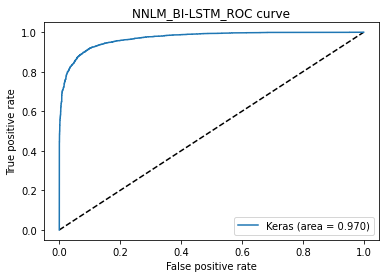

In [28]:
from sklearn.metrics import roc_curve
y_pred=bi_model.predict(test_x).ravel()
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
from sklearn.metrics import auc
auc_keras = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('NNLM_BI-LSTM_ROC curve')
plt.legend(loc='best')
plt.show()

In [29]:
from sklearn.metrics import roc_curve
import numpy as np
from sklearn.metrics import classification_report
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
y=tpr-fpr
idx=np.argmax(y)#Youden_index
best_threshold=thresholds[idx]
print("The best threshold is",best_threshold)
print(classification_report(test_y, y_pred >best_threshold ,digits=4))

The best threshold is 0.6594613
              precision    recall  f1-score   support

           0     0.9028    0.9214    0.9120      4162
           1     0.9174    0.8979    0.9076      4046

    accuracy                         0.9098      8208
   macro avg     0.9101    0.9097    0.9098      8208
weighted avg     0.9100    0.9098    0.9098      8208



In [30]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

from tensorflow.keras.layers import Dropout
lstm_model=Sequential()
lstm_model.add(hub_layer)
lstm_model.add(tf.keras.layers.Reshape((1,128)))
lstm_model.add(LSTM(64))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1,activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(3e-3),metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 128)               124642688 
                                                                 
 reshape_5 (Reshape)         (None, 1, 128)            0         
                                                                 
 lstm_4 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 124,692,161
Trainable params: 124,692,161
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
callback=keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=5, verbose=2, mode='auto', restore_best_weights=True)
history = lstm_model.fit(x=train_x, y=train_y, batch_size=64, verbose=1, epochs=20, validation_split= 0.1,shuffle=True,callbacks=[callback])

Epoch 1/20
462/462 [==============================] - 58s 120ms/step - loss: 0.1661 - accuracy: 0.9380 - val_loss: 0.2513 - val_accuracy: 0.9004
Epoch 2/20
462/462 [==============================] - 54s 118ms/step - loss: 0.0805 - accuracy: 0.9704 - val_loss: 0.3473 - val_accuracy: 0.8986
Epoch 3/20
462/462 [==============================] - 54s 117ms/step - loss: 0.0450 - accuracy: 0.9829 - val_loss: 0.4653 - val_accuracy: 0.8910
Epoch 4/20
462/462 [==============================] - 54s 118ms/step - loss: 0.0297 - accuracy: 0.9883 - val_loss: 0.5423 - val_accuracy: 0.8919
Epoch 5/20
462/462 [==============================] - 54s 117ms/step - loss: 0.0237 - accuracy: 0.9911 - val_loss: 0.5972 - val_accuracy: 0.8898
Epoch 6/20
462/462 [==============================] - 54s 118ms/step - loss: 0.0161 - accuracy: 0.9936 - val_loss: 0.6935 - val_accuracy: 0.8864
Epoch 00006: early stopping


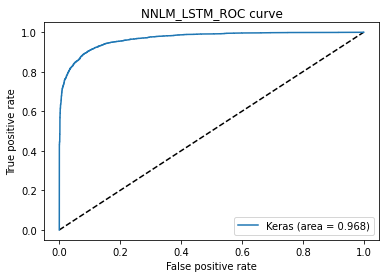

In [32]:
from sklearn.metrics import roc_curve
y_pred=lstm_model.predict(test_x).ravel()
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
from sklearn.metrics import auc
auc_keras = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('NNLM_LSTM_ROC curve')
plt.legend(loc='best')
plt.show()

In [33]:
from sklearn.metrics import roc_curve
import numpy as np
from sklearn.metrics import classification_report
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
y=tpr-fpr
idx=np.argmax(y)#Youden_index
best_threshold=thresholds[idx]
print("The best threshold is",best_threshold)
print(classification_report(test_y, y_pred >best_threshold ,digits=4))

The best threshold is 0.68088305
              precision    recall  f1-score   support

           0     0.8973    0.9178    0.9075      4162
           1     0.9134    0.8920    0.9026      4046

    accuracy                         0.9051      8208
   macro avg     0.9054    0.9049    0.9050      8208
weighted avg     0.9053    0.9051    0.9051      8208



In [34]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

from tensorflow.keras.layers import Dropout
lstm_model=Sequential()
lstm_model.add(hub_layer)
lstm_model.add(tf.keras.layers.Reshape((1,128)))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(64,return_sequences=True))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1,activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(3e-3),metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 128)               124642688 
                                                                 
 reshape_6 (Reshape)         (None, 1, 128)            0         
                                                                 
 dropout_8 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_5 (LSTM)               (None, 1, 64)             49408     
                                                                 
 dropout_9 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_6 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 1)                

In [35]:
callback=keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=5, verbose=2, mode='auto', restore_best_weights=True)
history = lstm_model.fit(x=train_x, y=train_y, batch_size=64, verbose=1, epochs=20, validation_split= 0.1,shuffle=True,callbacks=[callback])

Epoch 1/20
462/462 [==============================] - 61s 123ms/step - loss: 0.1117 - accuracy: 0.9636 - val_loss: 0.2839 - val_accuracy: 0.8986
Epoch 2/20
462/462 [==============================] - 56s 120ms/step - loss: 0.0612 - accuracy: 0.9780 - val_loss: 0.3653 - val_accuracy: 0.8986
Epoch 3/20
462/462 [==============================] - 55s 120ms/step - loss: 0.0404 - accuracy: 0.9850 - val_loss: 0.4340 - val_accuracy: 0.8980
Epoch 4/20
462/462 [==============================] - 55s 120ms/step - loss: 0.0307 - accuracy: 0.9879 - val_loss: 0.5310 - val_accuracy: 0.8934
Epoch 5/20
462/462 [==============================] - 55s 120ms/step - loss: 0.0228 - accuracy: 0.9913 - val_loss: 0.5654 - val_accuracy: 0.8980
Epoch 6/20
462/462 [==============================] - 56s 120ms/step - loss: 0.0171 - accuracy: 0.9939 - val_loss: 0.6176 - val_accuracy: 0.8840
Epoch 00006: early stopping


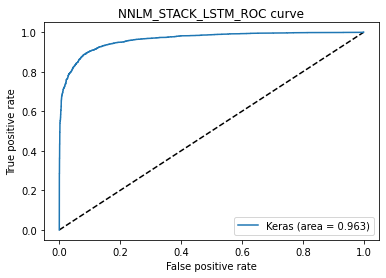

In [36]:
from sklearn.metrics import roc_curve
y_pred=lstm_model.predict(test_x).ravel()
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
from sklearn.metrics import auc
auc_keras = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('NNLM_STACK_LSTM_ROC curve')
plt.legend(loc='best')
plt.show()

In [37]:
from sklearn.metrics import roc_curve
import numpy as np
from sklearn.metrics import classification_report
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
y=tpr-fpr
idx=np.argmax(y)#Youden_index
best_threshold=thresholds[idx]
print("The best threshold is",best_threshold)
print(classification_report(test_y, y_pred >best_threshold ,digits=4))

The best threshold is 0.5695874
              precision    recall  f1-score   support

           0     0.8927    0.9200    0.9062      4162
           1     0.9150    0.8863    0.9004      4046

    accuracy                         0.9034      8208
   macro avg     0.9039    0.9031    0.9033      8208
weighted avg     0.9037    0.9034    0.9033      8208

